In [4]:
import os
import fnmatch

directory = "./"
search_string = "testfile_2023-11-11-15:35:40_random_forest"

matching_files = []

for filename in os.listdir(directory):
    if fnmatch.fnmatch(filename, f"*{search_string}*"):
        matching_files.append(filename)

print("Matching files:")
for file in matching_files:
    print(file)

Matching files:
testfile_2023-11-11-15:35:40_random_forest


In [5]:
with open(matching_files[-1], 'r') as file:
    content = file.readlines()

In [6]:
import numpy as np

content = [[float(x) for x in row.split(',')[:-1]] for row in content]

matrix = np.asarray(content[1:])

In [9]:
mean_weights = matrix.mean(axis=0)

In [14]:
%matplotlib inline

(array([ 21.,  41., 112., 128.,  28.,  24.,  18.,  21.,  34.,  40.,  31.,
         30.,  16.,  11.,   7.,   8.,   7.,   6.,   7.,   9.,   9.,   5.,
          5.,   5.,   3.,   5.,   4.,   4.,   6.,   6.,   5.,  15.,  19.,
          9.,   6.,   9.,   6.,   3.,   3.,   4.,   0.,  10.,   3.,   5.,
          6.,   2.,   6.,   1.,   0.,   5.]),
 array([0.01145652, 0.03122739, 0.05099826, 0.07076912, 0.09053999,
        0.11031086, 0.13008173, 0.1498526 , 0.16962347, 0.18939434,
        0.20916521, 0.22893608, 0.24870695, 0.26847782, 0.28824869,
        0.30801956, 0.32779043, 0.3475613 , 0.36733217, 0.38710303,
        0.4068739 , 0.42664477, 0.44641564, 0.46618651, 0.48595738,
        0.50572825, 0.52549912, 0.54526999, 0.56504086, 0.58481173,
        0.6045826 , 0.62435347, 0.64412434, 0.66389521, 0.68366608,
        0.70343694, 0.72320781, 0.74297868, 0.76274955, 0.78252042,
        0.80229129, 0.82206216, 0.84183303, 0.8616039 , 0.88137477,
        0.90114564, 0.92091651, 0.94068738, 0.

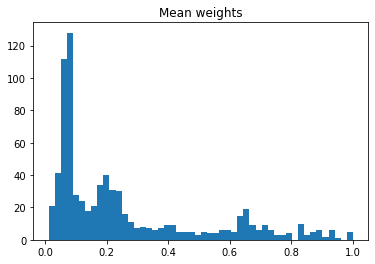

In [35]:
import matplotlib.pyplot as plt

plt.title("Mean weights")
plt.hist(mean_weights, bins=50)

In [19]:
mean_weights = [x if x != 1 else 0.999999 for x in mean_weights]

### Fit beta function to average values

In [33]:
from scipy.stats import beta
a, b, loc, scale = beta.fit(mean_weights, floc=0, fscale=1)

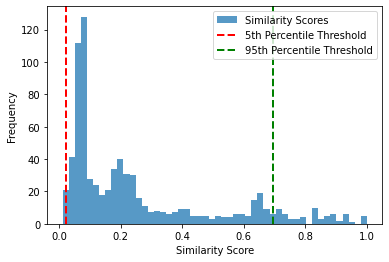

Lower threshold: 0.021673841010322423
Prototypes to prune below the lower threshold: [107 140 225 286 356 397 458 604 702]
Upper threshold: 0.6961121187651715
Prototypes to prune above the upper threshold: [  3   7  19  23  31  52  64  68  82 101 112 120 139 144 153 170 173 210
 211 238 276 281 290 310 322 328 342 347 355 380 382 384 427 432 454 464
 466 468 506 509 533 546 552 565 566 568 569 581 589 601 612 638 645 653
 688 690 691 732 743 749 757 760 764]


In [37]:
# Determine the 5th percentile threshold using the fitted Beta distribution.
# Prototypes with similarity scores below this threshold are less informative or outliers and can be pruned.
lower_threshold = beta.ppf(0.10, a, b, loc, scale)

# Determine the 95th percentile threshold using the fitted Beta distribution.
# Prototypes with similarity scores above this threshold are too common and can also be pruned.
upper_threshold = beta.ppf(0.90, a, b, loc, scale)

# Identify the pairwise comparison indices to prune based on the lower threshold.
lower_to_prune_indices = np.where(mean_weights < lower_threshold)[0]

# Identify the pairwise comparison indices to prune based on the upper threshold.
upper_to_prune_indices = np.where(mean_weights > upper_threshold)[0]

# Plot the histogram of the similarity scores with the pruning thresholds indicated.
plt.hist(mean_weights, bins=50, alpha=0.75, label='Similarity Scores')
plt.axvline(lower_threshold, color='r', linestyle='dashed', linewidth=2, label='5th Percentile Threshold')
plt.axvline(upper_threshold, color='g', linestyle='dashed', linewidth=2, label='95th Percentile Threshold')

plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Output the thresholds and the indices of pairwise comparisons that are candidates for pruning.
print(f'Lower threshold: {lower_threshold}')
print(f'Prototypes to prune below the lower threshold: {lower_to_prune_indices}')
print(f'Upper threshold: {upper_threshold}')
print(f'Prototypes to prune above the upper threshold: {upper_to_prune_indices}')

## Visualize dropped and kept prototypes

In [19]:
from proto_drop_vis import visualize_topk_dropped
import os

cwd = os.getcwd()

proto_dropped  = list(set(lower_to_prune_indices).union(upper_to_prune_indices))
proto_kept = list(set(range(0, len(mean_weights))).difference(set(proto_dropped)))
LOG_DIR = os.path.join(cwd, "runs/plankton_test_2023_11_11_1530_768_protos_full_vis")
PATH_TRAINED_MODEL =  os.path.join(cwd, "runs/plankton/checkpoints/net_trained_60")
to_sample  = 20

In [20]:
visualize_topk_dropped(proto_dropped, proto_kept, LOG_DIR, PATH_TRAINED_MODEL, 'dropped_kept_protos_258_beta_pruning', k=10, to_sample=to_sample)

CUDA device set without id specification
Device used:  cuda with id [0]
Number of prototypes:  768
chosen network is convnext
Pretrained network loaded
Num classes (k) =  86 ['Amphidinium_sp', 'Asterionellopsis', 'Cerataulina', 'Cerataulina_flagellate', 'Ceratium'] etc.
Visualizing prototypes for topk...


/sw/arch/RHEL8/EB_production/2022/software/PyTorch/1.12.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

0 prototypes do not have any similarity score > 0.1. Will be ignored in visualisation.



Visualizing topk: 100% 3096/3096 [01:48<00:00, 28.43it/s]

Abstained:  0


###  Inspect similarty scores for hand pick all grey prototypes

In [22]:
# Get the mean weights of specifically selected grey prototypes
grey_prototypes = [6, 42, 15, 46, 51, 52, 69, 87, 97]
mean_weights_grey_prototypes = {idx: x for idx, x in enumerate(mean_weights) if idx in grey_prototypes}

In [23]:
mean_weights_grey_prototypes

{6: 0.34969485303590764,
 15: 0.07755098192329833,
 42: 0.3620353210193128,
 46: 0.22683159323662513,
 51: 0.5848466288260842,
 52: 0.8392914106317615,
 69: 0.3970578425206099,
 87: 0.4411432139543741,
 97: 0.47665319619040525}

In [24]:
# Most important prototype
index =  np.where(mean_weights == max(mean_weights))[0]

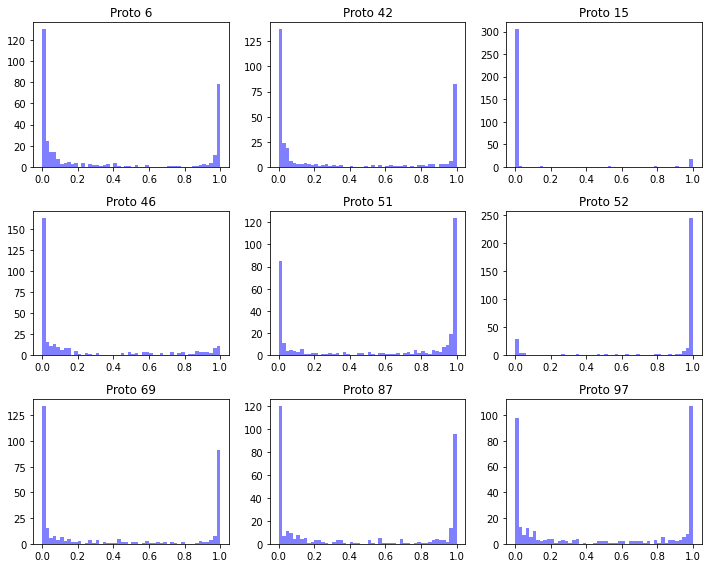

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

for idx, proto in enumerate(grey_prototypes):
    data = matrix[:, proto]
    axs[idx//3, idx%3].hist(data, bins=50, alpha=0.5, color='blue', range=(0,1))
    axs[idx//3, idx%3].set_title(f'Proto {proto}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Try the same but with not grey prototypes 

In [26]:
useful_prototypes = [33, 38, 79, 91, 104, 125, 134, 136, 172]
mean_weights_useful_prototypes = {idx: x for idx, x in enumerate(mean_weights) if idx in useful_prototypes}

In [27]:
mean_weights_useful_prototypes

{33: 0.041211923096296225,
 38: 0.04146475464857749,
 79: 0.14857069105501727,
 91: 0.21150910716603324,
 104: 0.2652747280810564,
 125: 0.25352526561258804,
 134: 0.0797109311694894,
 136: 0.10467893534744602,
 172: 0.10124296215167403}

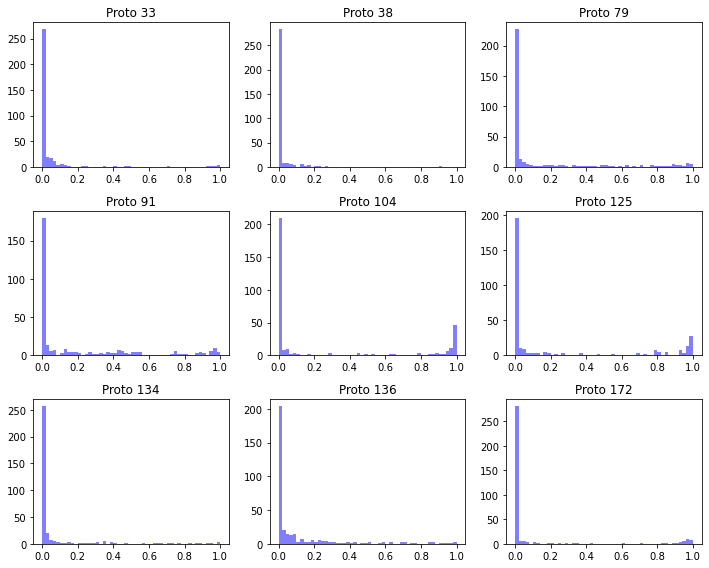

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

for idx, proto in enumerate(useful_prototypes):
    data = matrix[:, proto]
    axs[idx//3, idx%3].hist(data, bins=50, alpha=0.5, color='blue', range=(0,1))
    axs[idx//3, idx%3].set_title(f'Proto {proto}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()